In [1]:
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import brown

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
tagged_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')

In [4]:
print(tagged_sentences[0])

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


In [5]:
brown_data_sentences = []
brown_data_tags = []
for data in tagged_sentences:
  sentences = []
  tags = []
  for word_tag in data:
    sentences.append(word_tag[0])
    tags.append(word_tag[1])
  brown_data_sentences.append(sentences)
  brown_data_tags.append(tags)
#brown_data_tags[1]
#brown_data_sentences[1]

In [6]:
unique_words = set([words.lower() for sentence in brown_data_sentences for words in sentence])
unique_tags = set([t.lower() for sentence in brown_data_tags for t in sentence])
print("Number of Unique words = ",len(unique_words))
print("Number of Unique tags = ",len(unique_tags))

Number of Unique words =  49815
Number of Unique tags =  12


In [7]:
unique_tags

{'.',
 'adj',
 'adp',
 'adv',
 'conj',
 'det',
 'noun',
 'num',
 'pron',
 'prt',
 'verb',
 'x'}

In [8]:
from tqdm.notebook import tqdm

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.models import Model
from keras.preprocessing.text import Tokenizer

In [12]:
word_tokenizer = Tokenizer()              
word_tokenizer.fit_on_texts(brown_data_sentences)            
X_encoded = word_tokenizer.texts_to_sequences(brown_data_sentences)  
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(brown_data_tags)
Y_encoded = tag_tokenizer.texts_to_sequences(brown_data_tags)

In [13]:
print(brown_data_sentences[1])

['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']


In [14]:
print(X_encoded[1])

[1, 1634, 439, 62, 8, 27806, 27807, 9, 1, 238, 2028, 602, 2, 37, 27, 3107, 861, 4, 1, 1401, 2, 14, 5685, 1, 5434, 5, 2954, 4, 1, 238, 4, 3108, 15, 13, 1, 850, 8, 37, 1, 1401, 11, 2029, 3]


In [15]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 180


In [16]:


MAX_SEQ_LENGTH = 180  
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")



In [17]:
X = X_padded
Y = Y_padded


# one-hot encode Y using to_categorical function provided in Keras
Y = to_categorical(Y)



In [18]:
import numpy as np

def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in tqdm(f):
            split_line = line.split()
            try:
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                glove_model[word] = embedding
            except:
                continue
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
glove2vec = load_glove_model('/content/drive/MyDrive/Glove/glove.6B.100d.txt')
# glove2vec = load_glove_model('/content/drive/MyDrive/glove.6B.100d.txt')

Loading Glove Model


0it [00:00, ?it/s]

400000 words loaded!


In [22]:
import numpy as np
EMBEDDING_SIZE  = 100  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = glove2vec[word]
    except KeyError:
        pass

In [23]:
# training procedure with 5 fold cross validation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
kf = KFold(n_splits=5)
kf.get_n_splits(X)
kfold_loss = []
kfold_accuracy = []
matrix_train = []
matrix_test = []
for train_index, test_index in kf.split(X):
  X_train_fold, Y_train_fold = X[train_index], Y[train_index]
  X_test_fold, Y_test_fold = X[test_index], Y[test_index]
  # print("TRAINING DATA")
  # print('Shape of input sequences: {}'.format(X_train_fold.shape))
  # print('Shape of output sequences: {}'.format(Y_train_fold.shape))
  # print("TESTING DATA")
  # print('Shape of input sequences: {}'.format(X_test_fold.shape))
  # print('Shape of output sequences: {}'.format(Y_test_fold.shape))
  print('--------------------------------------------------------------')


  model = Sequential()
  model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = False
  ))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(13, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
  training = model.fit(X_train_fold, Y_train_fold, batch_size=128, epochs=15)

  train_prediction = model.predict(X_train_fold)
  test_prediction = model.predict(X_test_fold)

  train_prediction = train_prediction.argmax(axis=-1)
  test_prediction = test_prediction.argmax(axis=-1)
  train_true = Y_train_fold.argmax(axis=-1)
  test_true = Y_test_fold.argmax(axis=-1)

  train_prediction_new = np.reshape(train_prediction,45872*180)
  train_true_new = np.reshape(train_true,45872*180)
  test_prediction_new = np.reshape(test_prediction,11468*180)
  test_true_new = np.reshape(test_true,11468*180)
  matrix_train.append(confusion_matrix(train_true_new,train_prediction_new))
  matrix_test.append(confusion_matrix(test_true_new,test_prediction_new))

  loss, accuracy = model.evaluate(X_test_fold, Y_test_fold, verbose = 1)
  kfold_loss.append(loss)
  kfold_accuracy.append(accuracy)
  print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))
  # visualise training history

--------------------------------------------------------------
Epoch 1/15
359/359 [==============================] - 5s 5ms/step - loss: 0.6742 - acc: 0.9706
Epoch 2/15
359/359 [==============================] - 2s 5ms/step - loss: 0.0472 - acc: 0.9889
Epoch 3/15
359/359 [==============================] - 2s 5ms/step - loss: 0.0406 - acc: 0.9904
Epoch 4/15
359/359 [==============================] - 2s 6ms/step - loss: 0.0379 - acc: 0.9909
Epoch 5/15
359/359 [==============================] - 2s 5ms/step - loss: 0.0363 - acc: 0.9913
Epoch 6/15
359/359 [==============================] - 3s 9ms/step - loss: 0.0353 - acc: 0.9915
Epoch 7/15
359/359 [==============================] - 3s 8ms/step - loss: 0.0346 - acc: 0.9917
Epoch 8/15
359/359 [==============================] - 3s 9ms/step - loss: 0.0340 - acc: 0.9919
Epoch 9/15
359/359 [==============================] - 3s 8ms/step - loss: 0.0337 - acc: 0.9919
Epoch 10/15
359/359 [==============================] - 3s 8ms/step - loss: 0.0333 

In [24]:
val2tag = {
            1 : 'NOUN',
            2 : 'VERB',
            3 : '.',
            4 : 'ADP',
            5 : 'DET',
            6 : 'ADJ',
            7 : 'ADV',
            8 : 'PRON',
            9 : 'CONJ',
            10 : 'PRT',
            11 : 'NUM',
            12 : 'X'
    
    }

In [25]:
cmtest = np.zeros((13,13))
temp = np.zeros((13,13))
for p in range(5):
  for q in range(13):
    for r in range(13):
      temp[q][r] = matrix_test[p][q][r]
  cmtest += temp
#print(cmtest)


In [26]:
cmtest = cmtest/5

In [27]:
# removing the pad label row and column
cmtest_new = np.zeros((12,12))
for aa in range(1,13):
  for bb in range(1,13):
    cmtest_new[aa-1][bb-1] = cmtest[aa][bb]
#print(cmtest_new)


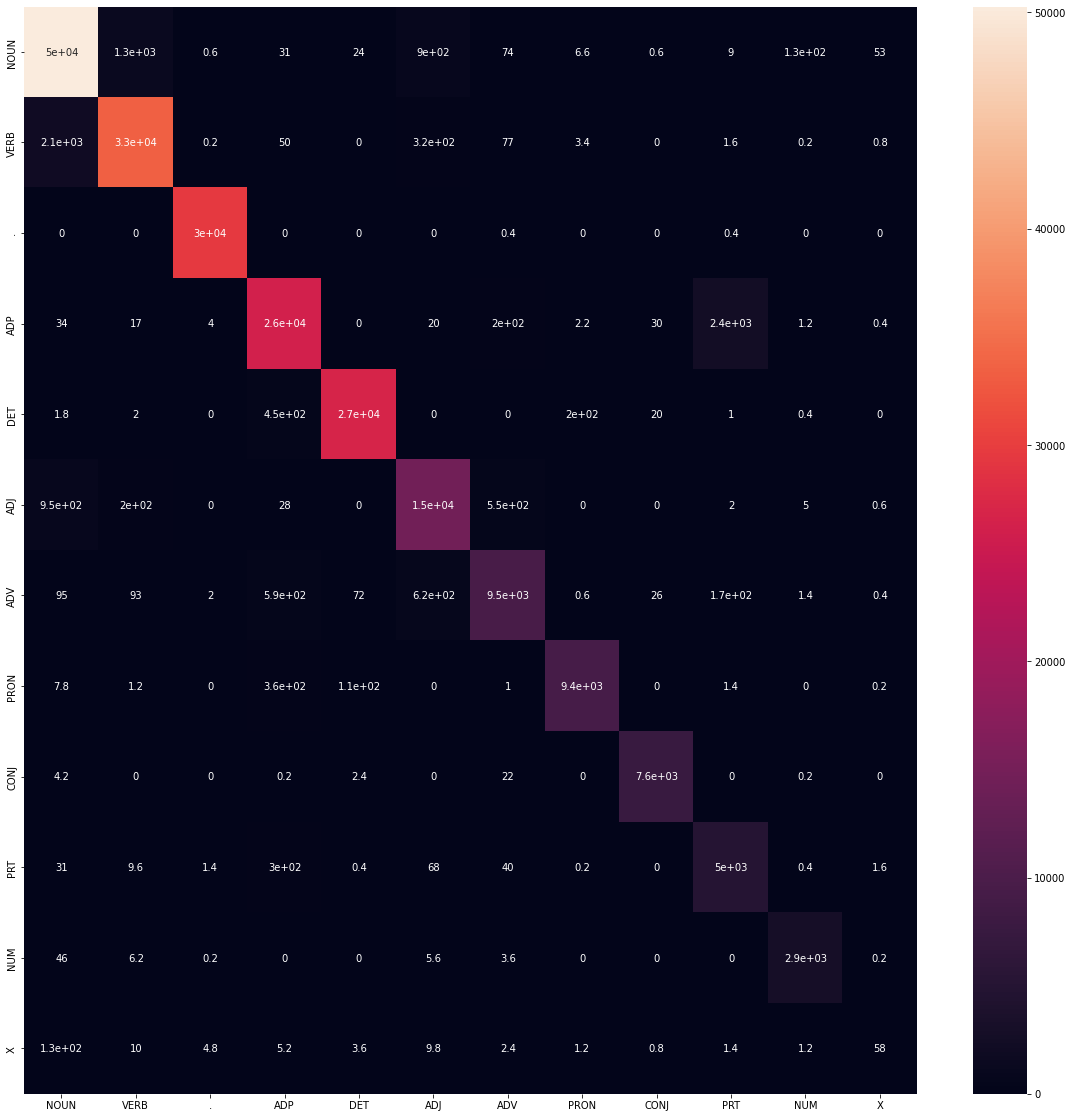

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

tag_list = [val2tag[i] for i in range(1,13)]
confusion_df = pd.DataFrame(cmtest_new, index=tag_list, columns=tag_list)
confusion_df.to_csv('bilstm_confusion_matrix.csv')
    
# plotting the heat map
plt.figure(figsize = (20, 20))
confusion_figure = sns.heatmap(cmtest_new, annot=True, xticklabels=tag_list, yticklabels=tag_list)
plt.savefig('bilstm_confusion_figure.png')

In [29]:
confusion_matrix =cmtest
tagkey = list(tag_tokenizer.word_index.keys())
per_pos_dict = {'tag': [], 'precision': [], 'recall': [], 'f1-score': []}
for tag_id in range(len(tagkey)):
  per_pos_dict['precision'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[tag_id, :]))
  per_pos_dict['recall'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[:, tag_id]))
  per_pos_dict['tag'].append(tagkey[tag_id])
  per_pos_dict['f1-score'].append(2 * per_pos_dict['precision'][tag_id] * per_pos_dict['recall'][tag_id] / (per_pos_dict['recall'][tag_id] + per_pos_dict['precision'][tag_id]))
per_pos_df = pd.DataFrame(per_pos_dict)
per_pos_df.to_csv('hmm_per_pos_accuracy.csv')

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 180, 100)          4981600   
                                                                 
 dense_12 (Dense)            (None, 180, 64)           6464      
                                                                 
 dense_13 (Dense)            (None, 180, 32)           2080      
                                                                 
 dense_14 (Dense)            (None, 180, 13)           429       
                                                                 
Total params: 4,990,573
Trainable params: 8,973
Non-trainable params: 4,981,600
_________________________________________________________________


In [31]:
print(per_pos_df)

     tag  precision    recall  f1-score
0   noun   1.000000  0.997816  0.998907
1   verb   0.912080  0.936157  0.923962
2      .   0.914566  0.953499  0.933627
3    adp   0.999973  0.999553  0.999763
4    det   0.905081  0.935165  0.919877
5    adj   0.975237  0.992137  0.983615
6    adv   0.870415  0.882238  0.876287
7   pron   0.847544  0.907421  0.876461
8   conj   0.950805  0.978105  0.964262
9    prt   0.996042  0.989996  0.993010
10   num   0.833652  0.655205  0.733735
11     x   0.958720  0.952954  0.955828


In [32]:
import re

In [33]:
def test(input):
  input = re.findall( r'\w+|[^\s\w]+', input)
  worddi = np.array([])
  for i in range(len(input)):
    if input[i] in word_tokenizer.word_index:
      worddi = np.append(worddi, word_tokenizer.word_index[input[i].lower()])
    else:
      worddi = np.append(worddi, word_tokenizer.word_index['jack'])
  worddi = worddi.reshape(-1, 1)
  predict = model.predict(worddi)
  inp_tags = []
  for i in range(len(worddi)):
    inp_tags.append(np.argmax(predict[i][0]))
  for i in range(len(inp_tags)):
    print(input[i].lower(), '--', tagkey[inp_tags[i]-1])

In [39]:
test_case = 'jack came back from work and he reeks of fish.'

In [40]:
test(test_case)

1/1 [==============================] - 0s 17ms/step
jack -- noun
came -- verb
back -- adv
from -- adp
work -- noun
and -- conj
he -- pron
reeks -- noun
of -- adp
fish -- noun
. -- .


In [36]:
Overall_precision = np.sum(per_pos_df['precision'])/12
Overall_recall = np.sum(per_pos_df['recall'])/12

In [37]:
f1_score = 2 * Overall_precision * Overall_recall / ( Overall_precision + Overall_recall)
f_half_score = 1.25 * Overall_precision * Overall_recall / ( (0.25*Overall_precision) + Overall_recall)
f2_score = 5 * Overall_precision * Overall_recall / ( (4*Overall_precision) + Overall_recall)

In [38]:
print("Precision: ",Overall_precision)
print("Recall: ",Overall_recall)
print("F1_score: ",f1_score)
print("F0.5_score: ",f_half_score)
print("F2_score: ",f2_score)

Precision:  0.9303428843476017
Recall:  0.931687196996957
F1_score:  0.9310145554017896
F0.5_score:  0.930611436438834
F2_score:  0.9314180237593812
